**Machine Learning Basic Principles 2018 - Data Analysis Project Report. Group 256, Mathias Smeds and Mathias Fontell**

# *Music genre classification from MFCCs, chroma and rhythm patterns using  supervised ML methods* 

## Abstract

We investigate music genre classification from audio files decomposed into mel-frequency cepstral coefficients, chroma values and rhythm patterns using supervised machine learning methods. For a training dataset of roughly 5000 labeled songs, each song has been decomposed into 264 features, from which the correct genre of the song is to be predicted using supervised multiclass classifiers. We investigate the necessity for dimensionality reduction using principal component analysis and feature scalng, and find that the used features exhibit differences in value ranges up to six orders of magnitude as well as noticeable redundancy. Finally, we apply two different classifiers for genre classification, which we crossvalidate with a separate validation dataset. Our results obtain the highest accuracy using the random forest classifier using 100 estimators and a max depth of 10, with which we achieve a prediction accuracy of 59 percent.

## 1. Introduction (SMEDS)

*Background, problem statement, motivation, many references, description of
contents. Introduces the reader to the topic and the broad context within which your
research/project fits*

*- What do you hope to learn from the project?*
*- What question is being addressed?*
*- Why is this task important? (motivation)*

*Keep it short (half to 1 page).*

.-.-.-.-.-.-.-.-

Assigning a genre to a song is a task at which even humans might have different opinions as to what is the correct genre. Thus we can expect that teaching a computer to correctly predict a genre for a given song is no easy feat.

Our task is to teach a computer to assign a genre to a song, based on data features extracted from the song. The two most important outcomes from this project are

1. How well can a computer predict the genre of a song based on simple Machine Learning algorithms
2. What preprocessing of the data is needed

We have two datasets consisting of song features, with one of the datasets being labeled to specific genres. Depending on the bitrate and audio format a single song can be several tens of megabytes, with normal listening bitrate for an mp3-file requiring at least a few megabytes. This means that using all bits in the song would result in a huge dataset impractical for our purposes. Because of this we have a dataset consisting of features engineered from the song, so that one song does not take up too much storage and computational resources.

The project consists of preprocessing the data and finding a training a predictor which performs well both in assigning each song a genre as well as having good confidence in that assignment.

Googling "machine learning song genre" gives almost 8 million hits. It seems to be an interesting problem for developing ML algorithms, maybe because of it being hard to perform better than humans. Perhaps the most popular machine learning solution for music is tha Shazam-app which can come up with a song title based on a sample from a song. Even though Shazam is not centered around finding good accurate genre labels for songs, it is still close enough to this project to show that applying Machine Learning to music is relevant both for business and science purposes.



## 2. Data analysis (FONTELL)

### 2.1. Overview of the data

Before diving headfirst into classification and any derived machine earning (pun intended), we are well advised to familiarize ourselves with the data at hand. There are several reasons for doing this. First of all, identifying significant features or redundancy helps in finding a machine learning method most suitable for the data; the difference between trends that appear linear, polynomial, clustered or something completely alien can single out certain methods from the getgo. Moreover, filtering out redundant features improves the speed and often the accuracy of the selected classifier. As such, this section is tasked with addressing the following questions:

    - How are the classes distributed in the data? Is there a major representation of some classes?
    - What are the feature ranges, and is some pattern evident in the data?
    - Can the dimensionality of the data be reduced for improved speed and accuracy?

The songs in the dataset have been preprocessed into vectors of 264 features. The features contain information about the rhytm pattern, chroma and Mel Frequency Cepstral Coefficients (MFCC). Although a prior understanding of the technical details would certainly be useful, the conversion of an audio file into the MFCCs and rhythm/chroma patters is rather technical and well beyond the scope of this project. An overview of the procedure is presented in [1]; here we will not dwelve further into the details of the features. First, we start with investigating the class distribution.

Run the cell below to import the data and plot a histogram of the class distribution.

C:\Users\Mathias\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Mathias\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Mathias\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


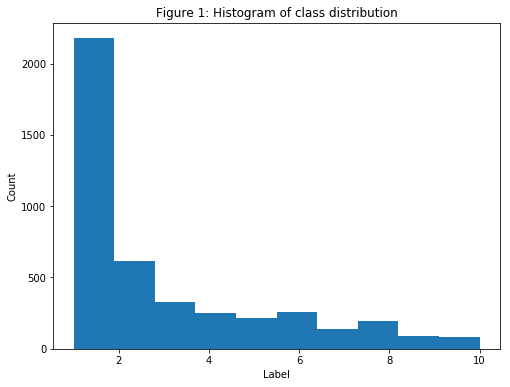

In [14]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import random
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import itertools

# Load the data and cleanup
train_data = pd.read_csv("train_data.csv", header=None).as_matrix()
test_data = pd.read_csv("test_data.csv", header=None).as_matrix()
train_labels = pd.read_csv("train_labels.csv", header=None).as_matrix()


#Histogram of class distribution
fig=plt.figure(figsize=(8,6))
plt.hist(train_labels[:,0])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Figure 1: Histogram of class distribution')
plt.show()

The histogram figure 1 shows that of the circa 4300 songs in the training dataset, almost 2000 represent label 1 i.e. pop. This appears to be a textbook example of an imbalanced dataset for classification; of the training labels, a disproportionate amount represent some label while some labels are wildly underrepresented. In the cells below, we present a function for undersampling a known genre by random selection to combat the imbalance. However, we will find out that this form of undersampling is not helpful - in fact, pop songs are so ubiquitous in any dataset we are likely to encounter, that we'd be well off trying to train our machine to at least classify pop songs correctly. Despite efforts, we have not found a way of undersampling the set without a reduction in the validation error. This will be elaborated on momentarily.

### 2.2. Features and range of variables

Then to the actual features. While the technical details of the features are rather complicated, it is prudent to at least investigate the feature range. In the cell below, we present scatter plots of a few selected column to better illuminate the data at hand. Run it to see what unfolds!

(900000.0, 1100000.0)

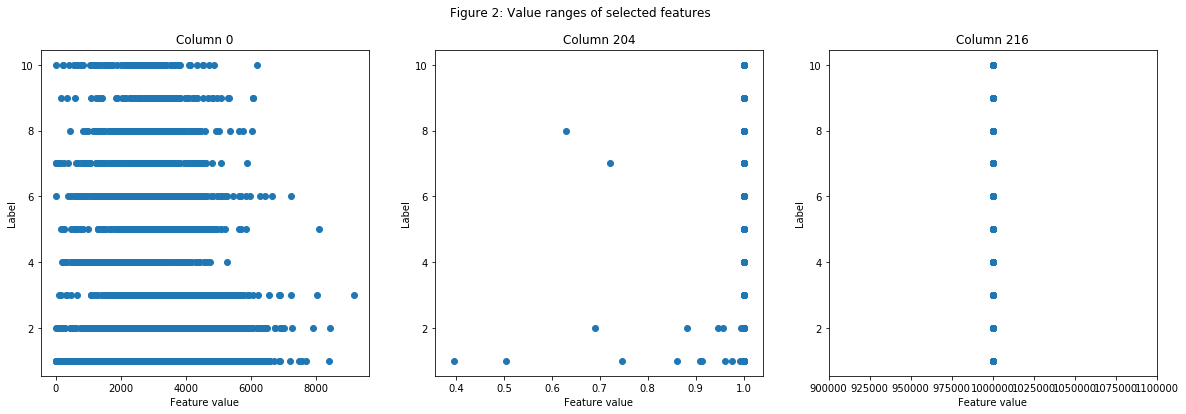

In [2]:
fig=plt.figure(figsize=(8,6))
fig.suptitle('Figure 2: Value ranges of selected features')
fig.set_figwidth(20)

plt.subplot(1,3,1)
plt.scatter(train_data[:,0],train_labels.ravel())
plt.title('Column 0')
plt.xlabel('Feature value')
plt.ylabel('Label')

plt.subplot(1,3,2)
plt.scatter(train_data[:,204],train_labels.ravel())
plt.title('Column 204')
plt.xlabel('Feature value')
plt.ylabel('Label')

plt.subplot(1,3,3)
plt.scatter(train_data[:,216],train_labels.ravel())
plt.title('Column 216')
plt.xlabel('Feature value')
plt.ylabel('Label')
plt.xlim([0.9e6,1.1e6])

Upon closer inspection of figure 2, one notices that the value ranges differ by several orders of magnitude. As an example, the first column of features (leftmost graph in figure 2) spans over several thousands, while the 205th column (middle graph) contains values strictly less than unity. Moreover, all the values in the 217th column (rightmost graph) are equal to $10^{6}$. These findings present two necessary courses of action: Scaling of the data, and dimension reduction. Feature scaling refers to the practice of normalizing the data to a certain range without loss of information. This practice proves to improve the performance of most machine learning methods [2], and will be presented in the cell below. Secondly, as some columns (e.g. column 216, rightmost graph in figure 2) contain values that are identical, the entire features corresponding to these columns are redundant and can be left out of the training set. This practice is known as dimensionality reduction, and improves the performance of machine learning methods by decreasing the risk of overfitting as well as reducing the time of computation and memory requirements.

### 2.3. Feature scaling and dimensionality reduction

The cell below walks through the process of linearly scaling the columns to a range $\in [0,1]$ for improved performance. In addition, we present a subroutine for randomly undersampling the data to combat class imbalance.

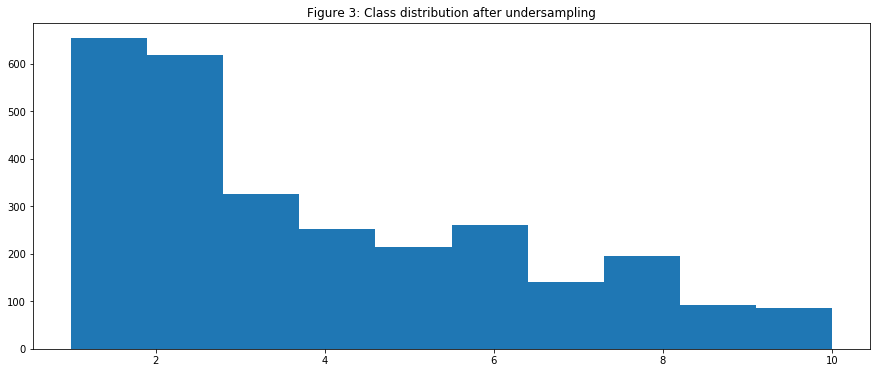

Text(0,0.5,'Label')

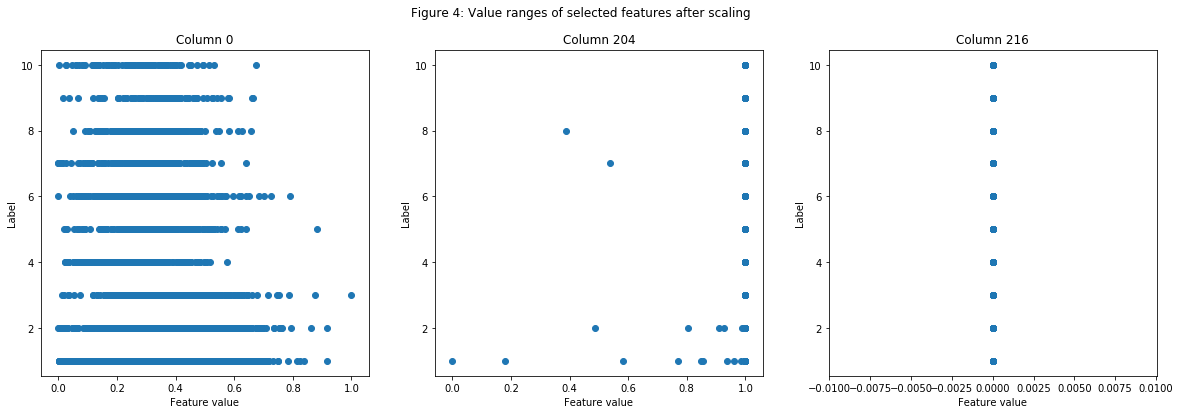

In [3]:
#normalize the data: Machine learning methods work better this way
from sklearn.preprocessing import MinMaxScaler

#The function my_minmaxscaler presents a possible implementation of scaling columns to a range [0,1]
#This function is omitted in favor of Python library functions for doing the same thing
def my_minmaxscaler(input_data):
    #Input: N x D matrix 'input_data' to be normalized
    #Output N x D matrix 'scaled_data', for which the columns j [0,D-1] have been normalized to [0,1] by the minmax procedure
    scaled_data=input_data
    for j in range(input_data.shape[1]):
        col=input_data[:,j]
        col_min=np.min(col)
        col_max=np.max(col)
    if(col_min==col_max):
        for i in range(input_data.shape[0]):
            scaled_data[i,j]=1.0
    else:
        for i in range(scaled_data.shape[0]):
            scaled_data[i,j]=(scaled_data[i,j]-col_min)/(col_max-col_min)
    return scaled_data

#We use the Python MinMaxScaler() instead
#We have found, that the method exhibits inexplicable floating point errors: some maxima are e.g. 0.999 or 1.002
#when supposed to be exactly 1.0
norm_data=MinMaxScaler().fit_transform(train_data)
norm_data_test=MinMaxScaler().fit_transform(test_data)

#Below is a possible implementation of an undersampling subroutine for randomly selecting some rows corresponding to 
#one genre to be left out of the data. We have found, that this does not help: see section 3 for results
def undersample_genre(features, labels, remaining, genre):
#Input: N x D features matrix, N x 1 labels matrix, remaining percentage of rows corresponding to label genre
#Output: (remaining*N) x D features matrix, (remaining*N) x 1 labels matrix
#remove some of those damn pop songs randomly
    N_data=features.shape[0]
    N_genre=0
    for i in range(N_data):
        if(labels[i]==genre):
            N_genre+=1
            
    to_delete=int(np.floor((1.0-remaining)*N_genre))
    deleted=0
    while(deleted<to_delete):
        #pick random row in tdata
        rand_row=randint(0, features.shape[0]-1)
        if(labels[rand_row]==genre):
            rand=random.uniform(0, 1)
            if(rand>remaining):
                #remove this row from tdata
                features = np.delete(features, (rand_row), axis=0)
                labels = np.delete(labels, (rand_row), axis=0)
                deleted+=1
    return features, labels

#Randomly remove 70% of the rows corresponding to label 1
undersampled_data, undersampled_labels = undersample_genre(train_data, train_labels, 0.3, 1)


fig=plt.figure(figsize=(8,6))
fig.set_figwidth(15)
plt.hist(undersampled_labels)
plt.title('Figure 3: Class distribution after undersampling')
plt.show()

fig=plt.figure(figsize=(8,6))
fig.suptitle('Figure 4: Value ranges of selected features after scaling')
fig.set_figwidth(20)

plt.subplot(1,3,1)
plt.scatter(norm_data[:,0],train_labels.ravel())
plt.title('Column 0')
plt.xlabel('Feature value')
plt.ylabel('Label')

plt.subplot(1,3,2)
plt.scatter(norm_data[:,204],train_labels.ravel())
plt.title('Column 204')
plt.xlabel('Feature value')
plt.ylabel('Label')

plt.subplot(1,3,3)
plt.scatter(norm_data[:,216],train_labels.ravel())
plt.title('Column 216')
plt.xlabel('Feature value')
plt.ylabel('Label')



After running the cell above, we see in figure 3 an example of undersampling the most represented genre. We are advised to try if undersampling improves our performance. Moreover, in figure 4 we observe the features from figure 2 after they have been linearly scaled. The machine learning methods used in this project will used these normalized datasets for both training, validation and prediction.

Moving on, we proceed to explore the possibilities of dimensionality reduction. A standard method of finding the most significant (or, the most informative) columns of the data is that of principal component analysis or PCA for short [3]. In essence, PCA indentifies the directions in which the data demonstrates the most variance, and projects the data points in said directions. While the  act of compressing the data this way comes at the benefit of reduced overfitting risk and computation resources for machine learning, we inevitably lose some of the information in the process. To this end, we are to study the eigenvalues $\lambda_i$ of the covariance matrix $\in \mathcal{R}^{D \times D}$, and evaluate the compression error of degree $d$ by calculating the sum of all eigenvalues of order $(d+1,...,D)$:

\begin{equation}
\epsilon(PCA \ degree \ d)=\sum_{i=d+1}^D \lambda_i
\end{equation}

It should also be said, that PCA performs better when done on the normalized data. Otherwise, the eigenvalues of the covariance matrix vary tremendously in magnitude, reducing the accuracy of projection.

In addition to PCA, we attempt dimensionality reduction by linear discriminant analysis or LDA, which is in essence a supervised classification method. Hence, LDA requires the labels of the data set, which we do not (obviously) have for the prediction scoring set. It is an experiment at best worth an effort.


C:\Users\Mathias\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


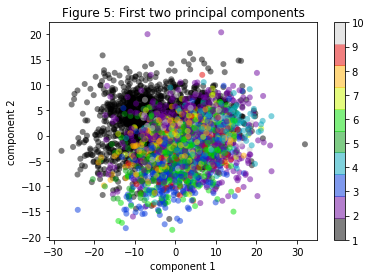

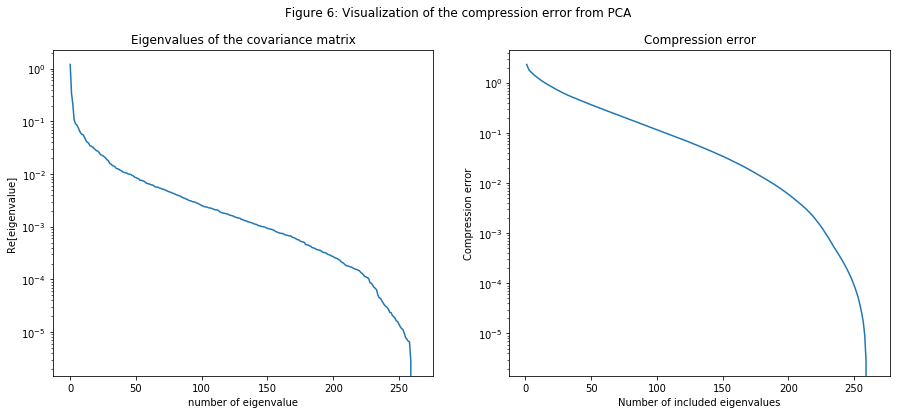

In [4]:
#Dimensionality reduction using PCA

#Find the eigenvalues of the covariance matrix and sort them
N=norm_data.shape[0]
C = np.cov(np.transpose(norm_data)) #data=normalize training data
values, vectors = np.linalg.eig(C)
idx = (values.real).argsort()[::-1]   
values_sorted = (values[idx]).real
vectors_sorted = vectors[:,idx]

#Perform principal component analysis on normalized data
data_for_PCA = StandardScaler().fit_transform(train_data)
data_for_PCA_test = StandardScaler().fit_transform(test_data)
pca = PCA(.97) #97 percent of the variance is left in the PCA
pca_data = pca.fit_transform(data_for_PCA)
pca_test_data = pca.fit_transform(data_for_PCA_test)

#Plot the first two components of PCA for visualization
plt.scatter(pca_data[:, 0], pca_data[:, 1],
            c=train_labels.ravel(), edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Figure 5: First two principal components')
plt.colorbar();

#Attempt a linear discriminant analysis
lda = LDA(n_components=10)
lda.fit(norm_data,train_labels.ravel())
lda_data=lda.transform(norm_data)
lda_data_test=lda.transform(norm_data_test)

#Sort the eigenvalues, and plot the real parts as well as the error of compression degree d
D=values_sorted.shape[0]
compression_error=np.zeros((1,D))
number_included=np.zeros((1,D))
for i in range(D):
    sum=0
    for j in range(i+1,D):
        sum+=values_sorted[j]
    compression_error[0,i]=sum
    number_included[0,i]=i+1
  
fig=plt.figure(figsize=(8,6))
fig.set_figwidth(15)
fig.suptitle('Figure 6: Visualization of the compression error from PCA')

plt.subplot(1,2,1)
plt.plot(values_sorted[:])
plt.xlabel('number of eigenvalue')
plt.semilogy()
plt.ylabel('Re[eigenvalue]')
plt.title("Eigenvalues of the covariance matrix")

plt.subplot(1,2,2)
plt.plot(number_included[0,:],compression_error[0,:])
plt.xlabel('Number of included eigenvalues')
plt.semilogy()
plt.ylabel('Compression error')
plt.title("Compression error")
plt.show()




#Output for classification
# train_data, test_data
# norm_data, norm_test_data
# pca_data, pca_test_data (normalised)
# lda_data, lda_test_data (normalised)
# undersampled_data, undersamples_test_data

 

Figure 5 represents the first two columns of PCA plotted against each other in a scatter plot, with the colorbar identifying the label of the datapoint. Figure 6 in turn represents the error of PCA compression. One should note, that the axes are logarithmic in figure 6: The error drops quickly, and between the compression degrees $\sim 20-200$, the error decreases as a straight line, implying a power law decrease. 

Finally we try a manual solution for choosing the best columns to include. By inspection we notice that columns 204-219 have almost all data points as the same value throughout each column. We drop these columns from the normalized data and keep the reduced dataset as a new feature matrix.

In [5]:
manual_data = np.delete(norm_data, np.s_[204:219], 1)
manual_test_data = np.delete(norm_data_test, np.s_[204:219], 1)

## 3. Methods and experiments (MATTE)

We started out by testing a few classifiers from scikit-learn.
- linear_model.LinearRegression
- linear_model.BayesianRidge
- sklearn.neural_network.MLPClassifier
- sklearn.svm.SVC
- sklearn.ensemble.RandomForestClassifier

On our full dataset without any modifications we got varied scoring on the training data. From about 30% with linear regression to 100% on Random Forest (which is obviously very overfitted). Because of the amount of code needed to show the intermediate results these are left out.

Out of these SVM and Random Forest seemed to be the most promising. We had two main options from here, try to find the best classifier by trial and error or try to get better results by understanding the data better. We decided that in order to learn the most from the project it would be useful to understand the data and what we can do with it, rather than blindly trying new classifiers until we would find improvement.

Understanding the data is explained in section 2 above. From section 2 we have an input of 5 different ways that we have processed the dataset.

- Full dataset
- Normalised dataset
- PCA-transformed dataset
- LDA-transformed dataset
- Undersampled dataset



In [46]:
#train_data, test_data
# norm_data, norm_data_test
# pca_data, pca_test_data (normalised)
# lda_data, lda_test_data (normalised)
# undersampled_data, undersamples_test_data
# manual_data, manual_test_data

As mentioned above it was easy to get very high training accuracy using a deep enough Random Forest, but that obviously did not yield good scores when submitting to kaggle. To get a reasonable guess on how to set up the Random Forest algorithm we can make use of cross validation as well as grid search.

In the cell below we do a grid search over 25 different parameter setups to find the best options for the Random Forest classifier. We find parameters using the LDA-transformed dataset, since it is significantly faster than using the full dataset. We choose 5-fold cross validation, which means that for each parameter setup the data is split and tested 5 times.

The grid search with cross validation is doing heavy calculations. This means that the cell below takes a while to run. 

Running the grid search multiple times gives varied best parameters. Printing out the results for all runs shows that the mean score improves until a certain point and stops improving after that. This suggests that we are possibly starting to overfit the data even despite the cross validation. 

This seems to occur at a max depth of 10 and with 100 estimators. We manually refit the Random Forest classifier using these parameters.

In [6]:
#Set up random forest classifier
rfc = RandomForestClassifier()

#Set up grid for which setups to test
param_grid = {'n_estimators': [40, 60, 80, 100, 120], 'max_depth': [4, 6, 8, 10, 12]}

#Do grid search with 10-fold cross validation
grid_rfc = GridSearchCV(rfc, param_grid, cv=5)
grid_rfc.fit(lda_data, train_labels.ravel())
print(grid_rfc.grid_scores_)



[mean: 0.66193, std: 0.01192, params: {'max_depth': 4, 'n_estimators': 40}, mean: 0.66147, std: 0.01167, params: {'max_depth': 4, 'n_estimators': 60}, mean: 0.65872, std: 0.01253, params: {'max_depth': 4, 'n_estimators': 80}, mean: 0.66055, std: 0.01112, params: {'max_depth': 4, 'n_estimators': 100}, mean: 0.66170, std: 0.01579, params: {'max_depth': 4, 'n_estimators': 120}, mean: 0.70204, std: 0.00869, params: {'max_depth': 6, 'n_estimators': 40}, mean: 0.70387, std: 0.01159, params: {'max_depth': 6, 'n_estimators': 60}, mean: 0.69746, std: 0.01521, params: {'max_depth': 6, 'n_estimators': 80}, mean: 0.69814, std: 0.01367, params: {'max_depth': 6, 'n_estimators': 100}, mean: 0.69906, std: 0.01054, params: {'max_depth': 6, 'n_estimators': 120}, mean: 0.71396, std: 0.01162, params: {'max_depth': 8, 'n_estimators': 40}, mean: 0.71212, std: 0.01218, params: {'max_depth': 8, 'n_estimators': 60}, mean: 0.71075, std: 0.01468, params: {'max_depth': 8, 'n_estimators': 80}, mean: 0.71373, std: 

In [7]:
#Fit classifier to different permutations of dataset (Note: Cell may take a few minutes to run)
rfc = RandomForestClassifier(n_estimators=100, max_depth = 10).fit(train_data, train_labels.ravel())
rfc_norm = RandomForestClassifier(n_estimators=100, max_depth = 10).fit(norm_data, train_labels.ravel())
rfc_pca = RandomForestClassifier(n_estimators=100, max_depth = 10).fit(pca_data, train_labels.ravel())
rfc_lda = RandomForestClassifier(n_estimators=100, max_depth = 10).fit(lda_data, train_labels.ravel())
rfc_undersampled = RandomForestClassifier(n_estimators=100, max_depth = 10).fit(undersampled_data, undersampled_labels.ravel())
rfc_manual = RandomForestClassifier(n_estimators=100, max_depth = 10).fit(manual_data, train_labels.ravel())


In [8]:
#(Note: Cell may take a few minutes to run)
print("Cross validated Random Forest scores on test data\n") 
print("Full data score: ", np.mean(cross_val_score(rfc, train_data, train_labels.ravel(), cv=5)))
print("Normalised data score: ", np.mean(cross_val_score(rfc_norm, norm_data, train_labels.ravel(), cv=5)))
print("LDA data score: ", np.mean(cross_val_score(rfc_lda, lda_data, train_labels.ravel(), cv=5)))
print("PCA data score: ", np.mean(cross_val_score(rfc_pca, pca_data, train_labels.ravel(), cv=5)))
print("Undersampled data score: ", np.mean(cross_val_score(rfc_undersampled, undersampled_data, undersampled_labels.ravel(), cv=5)))
print("Manual data score: ", np.mean(cross_val_score(rfc_manual, manual_data, train_labels.ravel(), cv=5)))

Cross validated Random Forest scores on test data

Full data score:  0.5926948660340928
Normalised data score:  0.5926875312940126
LDA data score:  0.721520461885597
PCA data score:  0.542520162636304
Undersampled data score:  0.4966135616391639
Manual data score:  0.5924633818215232


At this point it looks like we have a very clear winner in the LDA data. Unfortunately it doesn't perform nearly as well on kaggle. The rest of the classifiers seem to have similar cross validation scores to the corresponding real kaggle results.

Based on this we choose the full dataset without modifications for the final classifier and output.

In [61]:
#Final algorithm output
rfc_output_accuracy = rfc.predict(test_data)
rfc_output_logloss = rfc.predict_proba(test_data)

## 4. Results (Output: Smeds, Confusion matrix: Fontell)

*Summarize the results of the experiments without discussing their implications.*

*- Include both performance measures (accuracy and LogLoss).*

*- How does it perform on kaggle compared to the train data.*

*- Include a confusion matrix.*



### 4.1. Performance of modified datasets (SMEDS)

Our experiments showed that the best cross validated performance was using LDA-sampled data. However, this was a false positive since the actual performance on Kaggle was significantly less. On Kaggle we got around 59% performance with out best classifier. The cross validation score is also 59% for this, which suggests that cross validation can be a good indicator of the real-world performance of a classifier.


### 4.2. Confusion matrix

One particularly nifty way of visualizing the performance of the classifier is the so-called confusion matrix. In each row $i$ of the confusion matrix, the count of predictions to class $j$ is given as the element $c_{ij}$. This way, it is easy to identify accurate predictions to a class as well as false positives and false negatives. The confusion matrix for our optimal classifier, the random forest classifier, is presented for the labeled data set that is randomly split into a validation set.

It can be seen, that almost all ($99.8\%$) of pop-rock songs are correctly predicted to be pop-rock songs. However, interestingly enough about $85\%$ of blues songs (class 10) are falsely predicted to be pop songs. It would be curious, that the machine sees such a strong resemblence between blues and pop somehow, although the genres are arguably very different to the human ear. Or are they? Well, unfortunately, blues is the least represented song in the entire dataset, containing only circa a hundred samples versus the two thousand pop songs. In fact, many songs of other genres are falsely predicted to be pop songs. The imbalance in the dataset is undeniably the culprit -- were there less pop songs and more of the other genres in nearly equal amounts, the machine learning method would be more suceptible to seeing both sides of the coin.

However, electronic music (class 2) is the second best represented genre with nearly 600 songs. But alas, very few of the other genres are falsely predicted to be electronic songs, in stark contrast to the case with pop. This suggests, that electronic music is the most distinct of the other genres, displaying MFCCs, chroma and rhythm patterns sufficiently different from other genres to not be mixed up by the machine. Arguably, electronic music is also quite distinct to the human ear -- the heavy use of synthesizers and regular repetitive beats simply seem to sound different to the computer as well. On another side note, it is interesting (but not that unexpected) that $4\%$ of jazz songs are falsely predicted to be blues. At the risk of sounding subjective to the point of betraying professionalism, the genres do sound alike.

The confusion matrix ultimately suggests, that far too many songs are falsely predicted to belong to the most represented class, i.e. pop songs. None of the other genres demonstrate false positives of this severity. One is certainly inclined to believe, that some form of suitable undersampling (or oversampling) could counteract this issue.


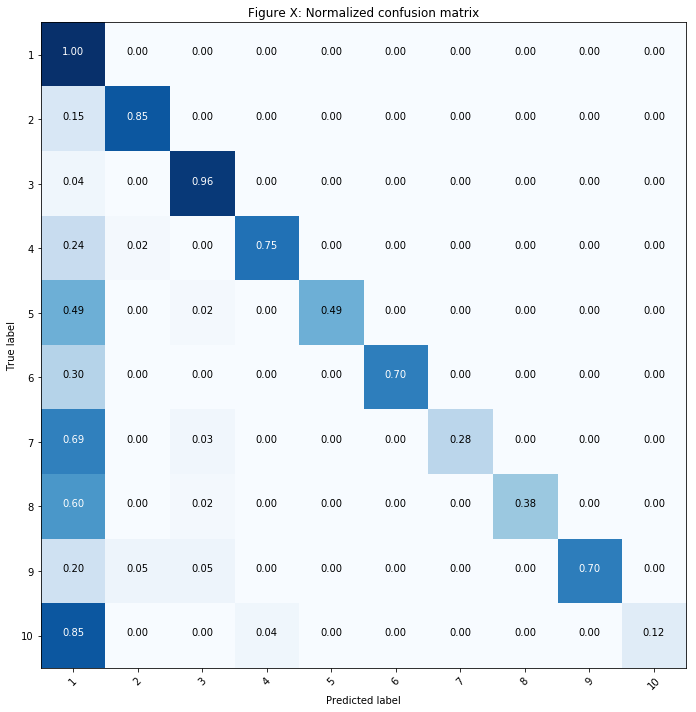

In [23]:
#Confusion matrix
cmap=plt.cm.Blues
classes=[1,2,3,4,5,6,7,8,9,10]
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels.ravel(), random_state=0)
y_pred=rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig=plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title("Figure X: Normalized confusion matrix")

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()


### 4.3. Output to Kaggle (SMEDS)

Matte, outputfiles här. Om dehär nu ens behöver en skild section


In [60]:
#Output for Accuracy competition
output_csv = pd.DataFrame({'Sample_label': rfc_output_accuracy})
output_csv.index += 1
output_csv.index.names = ['Sample_id']

#Output for Logloss competition
output_csv2 = pd.DataFrame(rfc_output_logloss, columns=['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5','Class_6','Class_7','Class_8','Class_9','Class_10',])
output_csv2.index += 1
output_csv2.index.names = ['Sample_id']

#output_csv.rename({1: "Sample_id", 2: "Sample_label"}, index=)
output_csv.to_csv('upload_to_kaggle_accuracy.csv')
output_csv2.to_csv('upload_to_kaggle_logloss.csv')


## 5. Discussion/Conclusions (SMEDS, I think)

*Interpret and explain your results *

*- Discuss the relevance of the performance measures (accuracy and LogLoss) for
imbalanced multiclass datasets. *

*- How the results relate to the literature. *

*- Suggestions for future research/improvement. *

*- Did the study answer your questions? *



We had expected to find significant improvement by understanding the data better, but were not able to convert the data-analysis into a better score. Despite effors in dimensionality reduction and feature scaling, the accuracy of attempted classifiers was not improved. For future work, a thorough understanding of the individual features and further investigations into dimensionality reduction is strongly advised, as the data was found to harbor significant redundancy. One possible approach is to consider the mean values of the MFCC, chroma and rhythm bands, which would reduce the sie of our datasets by a factor of four.

In [1], a similar procedure by only using the MFCCs is presented, by which a highest prediction accuracy of $80\%$ was achieved utilizing support vector machines using polynomial kernels. In our experiments however, the accuracies achieved by random forest and support vector classifiers were nearly equal. Interestingly enough, efforts in dimensionality reduction and feature scaling did not appear to improve the accuracy of the random forest classifier, although a PCA-transformed training set understandably translated to a reduced time required for fitting.

Unfortunately, the training set was found to harbor a significant class imbalance -- nearly half of the songs belonged to one genre, while only a few percent belonged to the least represented genres. From studying the confusion matrix, it was found that for the least represented classes more than half of the songs would be falsely classified into the most represented genre, a clear indication of severe imbalance. However, random undersampling was found to reduce accuracy of the classifier by nearly ten percentage points.  For further investigations, methods of combatting this class imbalance are to be attempted. The weaknesses of undersampling when using support vector classifiers are discussed in [4], where an alternative method of counteracting imbalanced is presented using a variation of the SMOTE (Synthetic minority oversampling technique) algorithm.

We were not able to find a good explanation for the big difference in LDA cross validation versus real world performance.

## 6. References

[1] N.M. Patil, M.U. Nemande: "Music Genre Classification Using MFCC, K-NN and SVM Classifier". International Journal of Computer Engineering In Research Trends, Vol. 4, Issue 2, pp 43-47, 2017.

[2] S. Tsakalidis, V. Doumpiotis and W. Byrne, "Discriminative Linear Transforms for Feature Normalization and Speaker Adaptation in HMM Estimation". Proc. ICSLP 02, 2003.

[3] C.O.S. Sorzano et al., "A survey of dimensionality reduction techniques". National Centre for Biotechnology, Spain, 2014.

[4] R. Akbani et al., "Applying Support Vector Machines to Imbalance Datasets". University of Texas at San Antonio, United States, 2004.

[5] B. Atman, S.U. Perman, "I am impressed you are actually checking the references: References [1]-[4] are legitimate though". Journal of Vanity and Boredom, Vol. 0, pp. 4-20, 200 B.C. 

## Appendix
*Any additional material needed to complete the report can be included here. For example, if you want to keep  additional source code, additional images or plots, mathematical derivations, etc. The content should be relevant to the report and should help explain or visualize something mentioned earlier. **You can remove the whole Appendix section if there is no need for it.** *